<a href="https://colab.research.google.com/github/ignaciobfp/Keyboard-Inspector/blob/master/Practica4_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 4: Variational Autoencoder

En este notebook se muestra cómo se puede definir un variational autoencoder. Para ello vamos a utilizar la librería [Keras](https://keras.io) y el dataset Quick, Draw!

## Un autoencoder básico

Comenzamos cargando las librerías necesarias. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

### Dataset

In [2]:
cosas = ["airplane", "car", "computer", "tree", "book"]
cosas = [ls+".npy" for ls in cosas]

In [3]:
import os
coco = []

import numpy as np
baseurl = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
for cosa in cosas:
  localurlcom = "wget " + baseurl + cosa
  os.system(localurlcom)
  coco.append(np.load(cosa))


In [4]:
coco=np.array(coco)
coco[2].shape

(123885, 784)

In [5]:
coco_reshaped = []
for i in range(len(coco)):
    #print(i)
    coco_i = np.reshape(coco[i], (len(coco[i]), 28, 28))
    coco_reshaped.append(coco_i)

In [6]:
from PIL import Image

for i in range(len(coco_reshaped)):
    print(coco_reshaped[i].shape)
    coco_1 = coco_reshaped[1]
    #Image.fromarray(coco_1[0])

Image.fromarray(coco_1[0])

(151623, 28, 28)
(182764, 28, 28)
(123885, 28, 28)
(144721, 28, 28)
(119364, 28, 28)


Vamos a juntar a continuación todas las imágenes en un solo array. Recordamos que no nos interesan las clases en esta práctica.

In [7]:
coco_ncatenated = np.concatenate(coco_reshaped, axis=0)

In [8]:
coco_ncatenated.shape

(722357, 28, 28)

In [9]:
from sklearn.model_selection import train_test_split
#x_train, x_test = train_test_split(coco_ncatenated, test_size=0.2, random_state=42)

# Crear un array numpy con los índices de clase para cada subconjunto de datos en coco_reshaped
y = np.concatenate([np.full((len(coco_reshaped[i]),), i, dtype=int) for i in range(len(coco_reshaped))])

# Dividir los datos en conjuntos de entrenamiento y prueba con una semilla aleatoria. Las ys nos harán falta al final, las creamos ahora.
x_train, x_test, y_train, y_test = train_test_split(coco_ncatenated, y, test_size=0.2, random_state=42)



Normalizamos el dataset y lo preparamos para poder alimentar al autoencoder.

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

### Autoencoder

Pasamos ahora a definir la arquitectura de nuestro autoencoder. Para ello lo primero que debemos hacer es definir la forma que tendrán los datos de entrada de nuestro autoencoder. El dataset MNIST consta de imágenes de tamaño $28\times 28$ en escala de grises, por lo que solo tienen un canal.

In [11]:
input_img = layers.Input(shape=(28,28,1))

Recordar que un autoencoder consta de un encoder y un decoder. Definimos a continuación nuestro encoder que va a constar de una pila de capas de convolución y de max pooling. Al aplicar el proceso de encoding llegamos a una reprentación final de tamaño (4,4,8) es decir 128 dimensiones, es decir hemos reducido casi a una sexta parte la codificación de nuestras imágenes.

In [12]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

El decoder se define mediante una pila de capas de convolución y de upsampling (capas con la función inversa que las de pooling). Notar que la entrada de la primera capa del decoder es la salida del encoder. Notar que la arquitectura es simétrica a la del encoder. 

In [13]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

Por último definimos nuestro modelo de autoencoder y lo compilamos. En Keras es necesario compilar un modelo para fijar el optimizador que se utilizará para entrenarlo (en este caso [ADAM](https://arxiv.org/abs/1412.6980) que es una variante del descenso de gradiente) y la función de pérdida (en este caso la [binary crossentropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class)).

In [14]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Con la siguiente instrucción podemos mostrar la arquitectura de una red de Keras. 

In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248  

También puede ser útil visualizar dicha red.

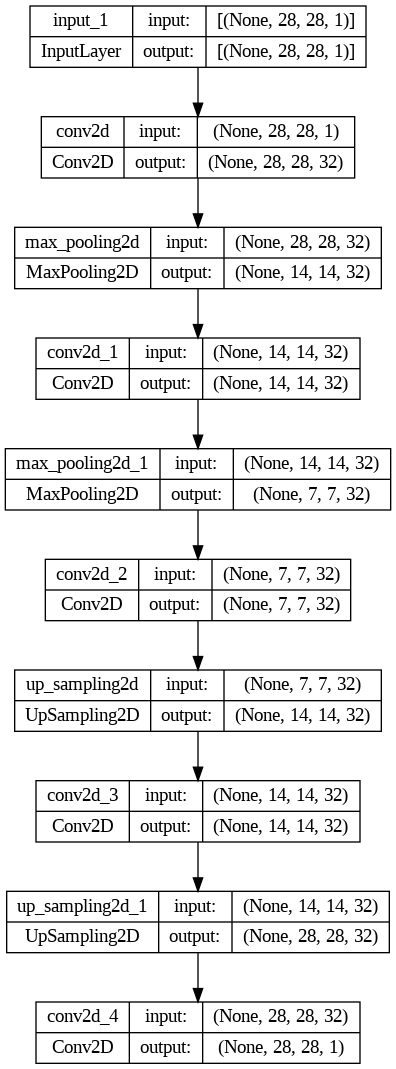

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='autoencoder_plot.png', show_shapes=True, show_layer_names=True)

Vamos ahora a entrenar nuestro modelo para ello usamos el método `fit` que está disponible para cualquier modelo de Keras. Utilizaré menos épocas ya que estos son bastantes más datos que en el cuaderno de ejemplo (unas 10 veces más). En lugar de 50, vamos a probar con 15. Recomendable usar batch_size de 256 (o más) si la instancia tiene suficiente RAM (colab pro o ejecutado en local, con los 12GiB de colab "normal" falla)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=128,
                validation_data=(x_test, x_test))

Epoch 1/15
4515/4515 [==============================] - 40s 6ms/step - loss: 0.1469 - val_loss: 0.1323
Epoch 2/15
4515/4515 [==============================] - 27s 6ms/step - loss: 0.1302 - val_loss: 0.1287
Epoch 3/15
4515/4515 [==============================] - 26s 6ms/step - loss: 0.1278 - val_loss: 0.1271
Epoch 4/15
4515/4515 [==============================] - 29s 6ms/step - loss: 0.1266 - val_loss: 0.1265
Epoch 5/15
4515/4515 [==============================] - 26s 6ms/step - loss: 0.1259 - val_loss: 0.1256
Epoch 6/15
4515/4515 [==============================] - 26s 6ms/step - loss: 0.1254 - val_loss: 0.1255
Epoch 7/15
4515/4515 [==============================] - 26s 6ms/step - loss: 0.1251 - val_loss: 0.1252
Epoch 8/15
4515/4515 [==============================] - 26s 6ms/step - loss: 0.1248 - val_loss: 0.1247
Epoch 9/15
4515/4515 [==============================] - 26s 6ms/step - loss: 0.1246 - val_loss: 0.1246
Epoch 10/15
4515/4515 [==============================] - 26s 6ms/step - l

Vamos a mostrar la reconstrucción de algunos de los trazos. Al ejecutar la siguiente celda, la primera fila muestra los dibujos originales y la segunda los reconstruidos. 

4515/4515 [==============================] - 8s 2ms/step


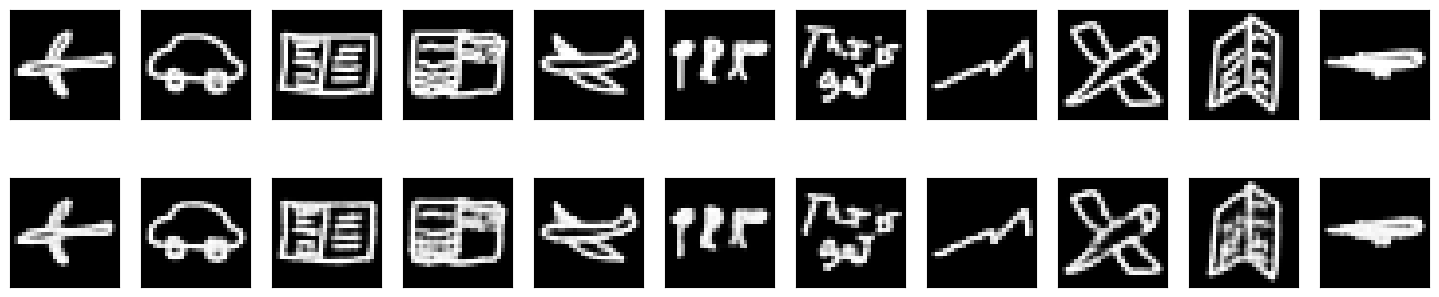

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 12
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Aplicación a la eliminación de ruido

Vamos a poner ahora a nuestro encoder a trabajar en el problema de la eliminación de ruido. Esto va a ser tan sencillo como entrenar nuestro autoencoder para mapear dígitos con ruido a imágenes limpias.

Para ello, el primer paso es construir nuestro dataset con ruido aplicando un ruido Gaussiano a las imágenes, y luego limitando los valores al rango de 0 a 1.

En primer lugar procedemos a añadir ruido a las imágenes del dataset de QuickDraw.

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Podemos ver a continuación algunas de las imágenes a las que se les ha añadido el ruido.

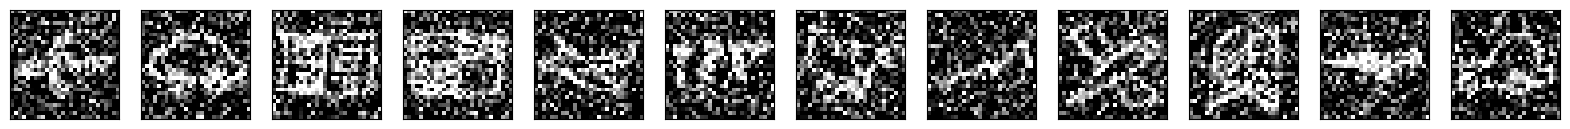

In [ ]:
n = 12
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Autoencoder

Pasamos ahora a definir la arquitectura de nuestro autoencoder. Para ello lo primero que debemos hacer es definir la forma que tendrán los datos de entrada de nuestro autoencoder. El dataset Quickdraw consta de imágenes de tamaño $28\times 28$ en escala de grises, por lo que solo tienen un canal.

In [ ]:
input_img = layers.Input(shape=(28,28,1))

Recordar que un autoencoder consta de un encoder y un decoder. Definimos a continuación nuestro encoder que va a constar de una pila de capas de convolución y de maxpooling.

In [ ]:
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

El decoder se define mediante una pila de capas de convolución y de upsampling (capas con la función inversa que las de pooling). Notar que la entrada de la primera capa del decoder es la salida del encoder; además, al igual que antes la arquitectura es simétrica al encoder. 

In [ ]:
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

Por último definimos nuestro modelo de autoencoder y lo compilamos.

In [ ]:
autoencoder_noise = keras.Model(input_img, decoded)
autoencoder_noise.compile(optimizer='adam', loss='binary_crossentropy')

Con la siguiente instrucción podemos mostrar la arquitectura del nuevo autoencoder. 

In [ ]:
autoencoder_noise.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248

También puede ser útil visualizar dicha red.

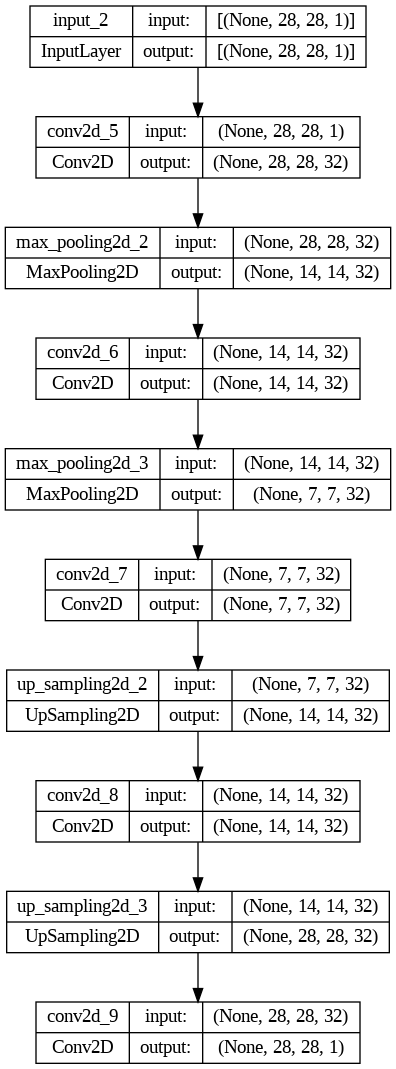

In [ ]:
plot_model(autoencoder_noise, to_file='autoencoder_noise_plot.png', show_shapes=True, show_layer_names=True)

Vamos ahora a entrenar nuestro modelo para ello usamos el método `fit` que está disponible para cualquier modelo de Keras.

In [ ]:
autoencoder_noise.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
4515/4515 [==============================] - 30s 6ms/step - loss: 0.2131 - val_loss: 0.1939
Epoch 2/20
4515/4515 [==============================] - 26s 6ms/step - loss: 0.1906 - val_loss: 0.1883
Epoch 3/20
4515/4515 [==============================] - 27s 6ms/step - loss: 0.1874 - val_loss: 0.1867
Epoch 4/20
4515/4515 [==============================] - 27s 6ms/step - loss: 0.1862 - val_loss: 0.1858
Epoch 5/20
4515/4515 [==============================] - 27s 6ms/step - loss: 0.1856 - val_loss: 0.1854
Epoch 6/20
4515/4515 [==============================] - 27s 6ms/step - loss: 0.1851 - val_loss: 0.1853
Epoch 7/20
4515/4515 [==============================] - 27s 6ms/step - loss: 0.1848 - val_loss: 0.1847
Epoch 8/20
4515/4515 [==============================] - 27s 6ms/step - loss: 0.1846 - val_loss: 0.1846
Epoch 9/20
4515/4515 [==============================] - 27s 6ms/step - loss: 0.1844 - val_loss: 0.1844
Epoch 10/20
4515/4515 [==============================] - 26s 6ms/step - l

Por último podemos predecir usando el modelo entrenado con las imágenes de test:

In [ ]:
decoded_imgs = autoencoder_noise.predict(x_test_noisy)

4515/4515 [==============================] - 7s 2ms/step


Y a continuación mostrar el resultado obtenido. 

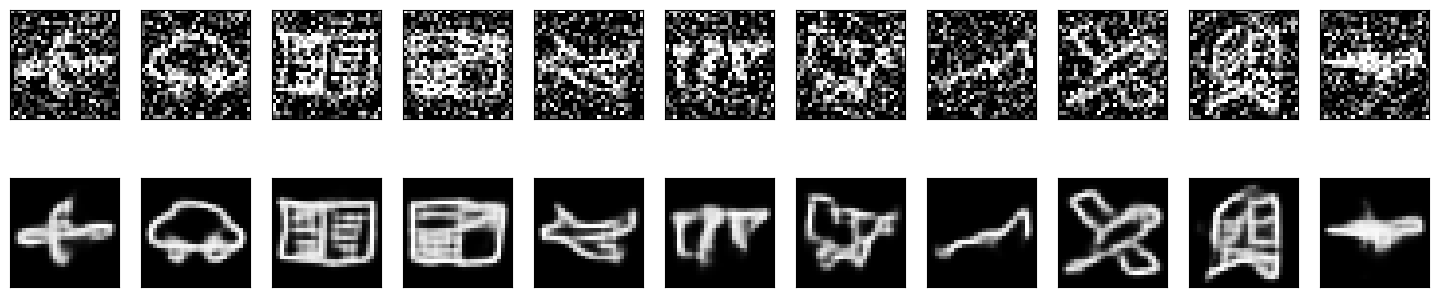

In [ ]:
n = 12
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational autoencoder

Como hemos visto en teoría un autoencoder toma una imagen, la mapea a un espacio vectorial subyacente por medio de un encoder, y seguidamente la decodifica a una salida con el tamaño de la imagen original. En la práctica, los autoencoders no son especialmente útiles, y han sido reemplazados por los variational autoencoders (o VAEs).

Un VAE en lugar de comprimir la imagen en un vector fijo en el espacio subyacente, la convierte a los parámetros de una distribución estadística (representada mediante una media y una varianza). Esencialmente, esto significa que asumimos que la imagen original ha sido generada mediante un proceso estadístico, y que la aleatoriedad de dicho proceso debe ser tomada en cuenta a la hora de proceso de codificación y decodificación. 

Un VAE usa los parámetros de media y varianza para tomar una muestra aleatoria de un elemento de la distribución, y decodifica dicho elemento de vuelta. Esto hace que mejore la robusted y fuerza a que el espacio subyacente obtenga representaciones significativas (notar que cualquier muestra de la distribución tiene que ser decodificada a una salida valida).

Desde el punto de vista técnico, un VAE funciona del siguiente modo:
1. Un encoder convierte la entrada en dos parámetros de un espacio subyacente de representaciones que denotaremos por `z_mean` y `z_log_var`.
2. Tomamos una muestra aleatoria `z` de la distribución normal que asumimos que genera la imagen de entrada mediante la fórmula `z = z_mean + exp(z_log_var)*epsilon` donde `epsilon` es un valor aleatorio pequeño.
3. La muestra `z` se decodifica.  Al tomar `epsilon` de manera aleatoria y con valor pequeño, el proceso asegura que cada punto que está cerca de la localización subyacente de la imagen puede ser decodificado a algo similar a la imagen de entrada. 

Para entrenar un VAE se usan dos funciones de pérdida: una que es la función de pérdida de reconstrucción que fuerza a que las muestras decodificadas se ajusten a las entradas iniciales, y una función de pérdida de regularización que ayuda a una formación correcta de los espacios subyacentes y a que no se produzca sobreajuste. 

### Capa de Sampling

Lo primero que vamos a definir es una nueva capa encargada de tomar una muestra aleatoria a partir de los valores de `z_mean` y `z_log_var`. Para ello debemos definir una nueva clase que hereda de la clase `Layer` de Keras y definir la función `call`.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

El encoder va a ser similar al encoder que vimos para el autoencoder, la principal diferencia es que va a producir dos vectores de salida, `z_mean` y `z_log_var`.

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_10[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_11[0][0]']              
                                                                                            

### Decoder

Ahora podemos definir el decoder, utilizando una arquitectura simétrica al encoder. 

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

Por último vamos a definir un nuevo modelo que une nuestro encoder y decoder definidos anteriormente, y definimos nuestra función de pérdida que va a tener en cuenta la función de pérdida de reconstrucción y la función de pérdida de regularización. Para ello debemos definir una nueva clase que herede de `Model`.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Entrenamiento

Finalmente, instanciamos el modelo y lo compilamos. Notar que no es necesario definir una función de pérdida de manera explícita ya que la hemos definido anteriormente. Esto supone que a la hora de entrenar el modelo no hará falta proporcionar la salida espera del modelo ya que es la misma que la entrada y de ello se encarga la capa definida anteriormente. 

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

Como nuestros datos originales no estaban separados en entrenamiento y test como sí ocurre en el dataset MNIST, podemos directamente utilizar la variable original, llamada coco_ncatenated

In [16]:
coco_ncatenated2 = np.expand_dims(coco_ncatenated, -1).astype("float32") / 255

In [ ]:
vae.fit(coco_ncatenated2, epochs=15, batch_size=128)

Epoch 1/15
5644/5644 [==============================] - 46s 8ms/step - loss: 286.5984 - reconstruction_loss: 266.0202 - kl_loss: 5.5706
Epoch 2/15
5644/5644 [==============================] - 42s 7ms/step - loss: 264.8553 - reconstruction_loss: 258.7989 - kl_loss: 5.5880
Epoch 3/15
5644/5644 [==============================] - 42s 7ms/step - loss: 263.6554 - reconstruction_loss: 257.7686 - kl_loss: 5.5343
Epoch 4/15
5644/5644 [==============================] - 42s 7ms/step - loss: 262.7914 - reconstruction_loss: 257.1732 - kl_loss: 5.5688
Epoch 5/15
5644/5644 [==============================] - 42s 7ms/step - loss: 262.3805 - reconstruction_loss: 256.7737 - kl_loss: 5.6125
Epoch 6/15
5644/5644 [==============================] - 42s 7ms/step - loss: 262.2671 - reconstruction_loss: 256.4745 - kl_loss: 5.6492
Epoch 7/15
5644/5644 [==============================] - 42s 8ms/step - loss: 261.9787 - reconstruction_loss: 256.2688 - kl_loss: 5.6696
Epoch 8/15
5644/5644 [==========================

Una vez que el modelo se ha entrenado, podemos usar el decoder para convertir puntos aleatorios del espacio subyacente en imágenes. 

1/1 [==============================] - 0s 16ms/step


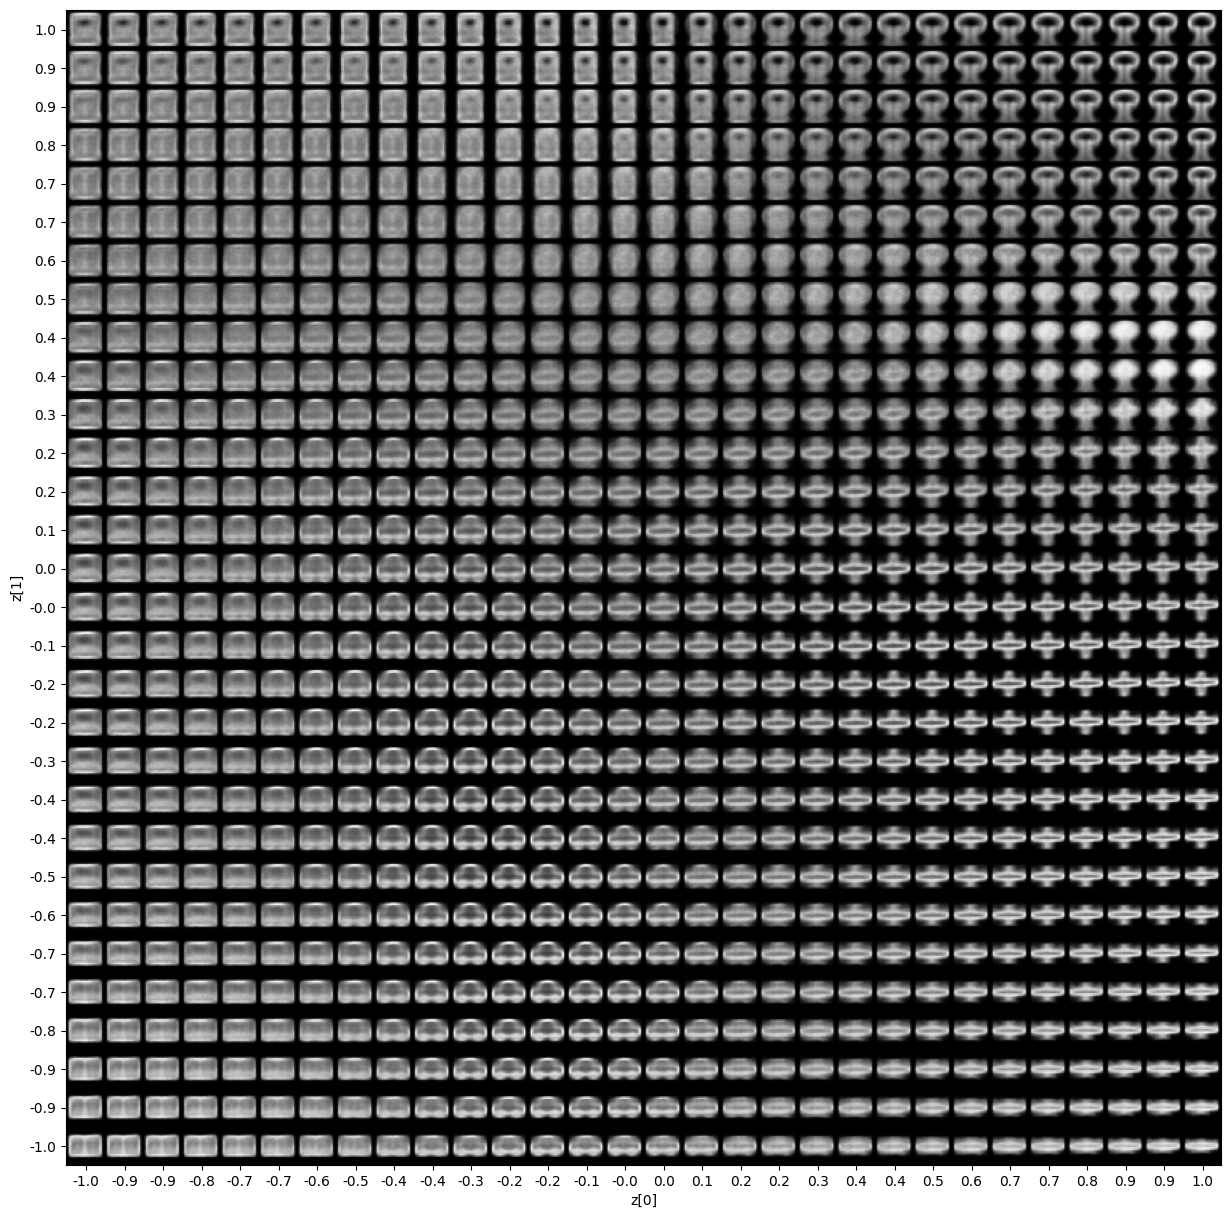

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

La cuadrícula anterior muestra una distribución continua de los dígitos de las distintas clases, y se puede ver cómo un dígito se transforma en otro al seguir un camino a través del espacio subyacente. Notar que hay direcciones subyacentes que tienen significado (como cuatri-ficar o uni-ficar).

Por último podemos ver los clústeres del espacio subyacente asociados a cada clase. 

18059/18059 [==============================] - 27s 1ms/step


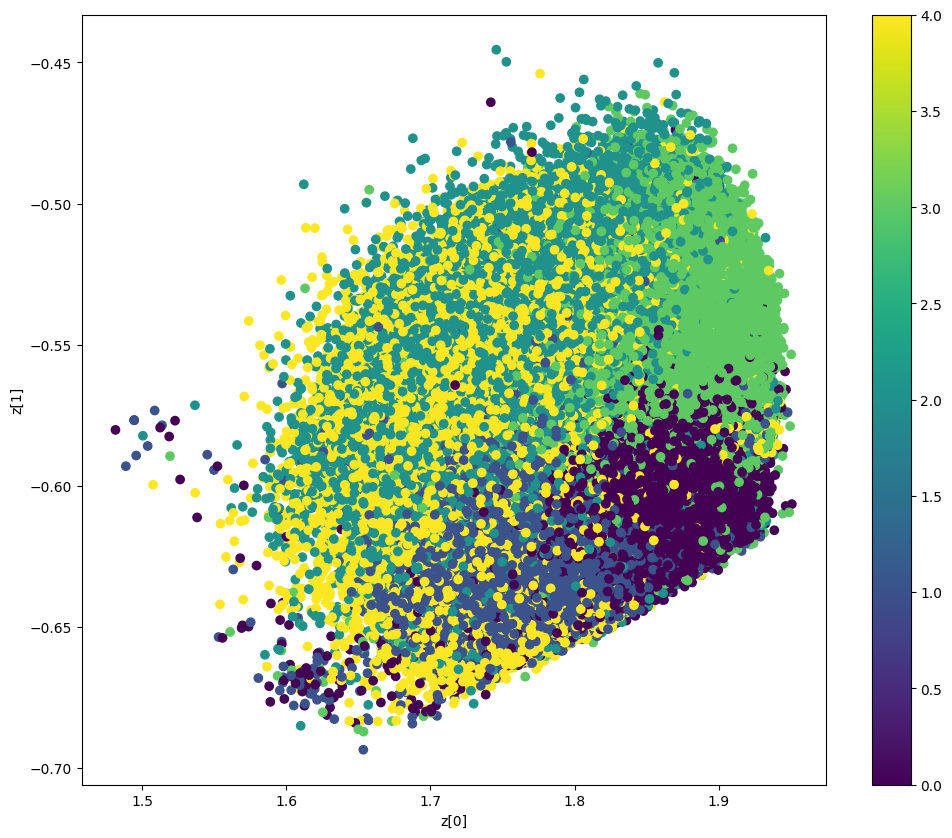

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.set_cmap('viridis')
    plt.show()


#(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

## Ejercicios opcionales

Para cada uno de los ejercicios opcionales crea un nuevo notebook dedicado a ello. 

- *GAN* (1 punto). Siguiendo el [tutorial de Keras sobre GANs](https://keras.io/examples/generative/dcgan_overriding_train_step/) reemplaza el variational autoencoder desarrollado en el ejercicio obligatorio con una GAN. 
- *Wasserstein GAN* (1 punto). Una manera de mejorar los resultados producidos por las GANs consiste en utilizar una variante llamada [Wasserstein GAN](https://arxiv.org/abs/1701.07875). Siguiendo el [tutorial de Keras sobre Wasserstein GANs](https://keras.io/examples/generative/wgan_gp/) reemplaza la GAN desarrollada en el ejercicio anterior con una Wasserstein GAN. 
- *Coloreado de imágenes* (1.5 puntos). Las GANs pueden usarse para tareas como la superresolución o el coloreado de imágenes. En el tutorioal de [Walk with FastAI](https://walkwithfastai.com/Super_Resolution) se explica cómo utilizar una GAN para obtener un modelo de super resolución. El ejercicio consiste en adaptar dicho modelo para el coloreado de imágenes.  
- *CycleGAN* (1.5 puntos). La librería [UPIT](https://github.com/tmabraham/UPIT) implementa un método de traducción entre imágenes sin emparejar llamado [CycleGAN](https://junyanz.github.io/CycleGAN/). Usando dicha librería crea un modelo para transformar manzanas a naranjas. Para ello puedes utilizar este notebook disponible en [Kaggle](https://www.kaggle.com/tanlikesmath/upit-a-package-for-unpaired-img2img-translation).

# GAN siguiendo el tutorial de Keras

## Setup

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Preparación de los datos


In [ ]:
#os.makedirs("celeba_gan")
#url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
#output = "celeba_gan/data.zip"
#gdown.download(url, output, quiet=True)
#with ZipFile("celeba_gan/data.zip", "r") as zipobj:
#    zipobj.extractall("celeba_gan")

Create a dataset from our folder, and rescale the images to the [0-1] range:

In [18]:
coco_ncatenated2.shape

(722357, 28, 28, 1)

Como son bastantes datos, vamos a reducir el conjunto para que se pueda entrenar en tiempos cortos

In [ ]:
#x_train, _, y_train, _ = train_test_split(coco_ncatenated2, y, test_size=0.9, random_state=42)


In [23]:
# Crear un Dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices(coco_ncatenated2).batch(128)

# La siguiente línea rellena con 0s hasta tamaño 32x32
# dataset = dataset.map(lambda x: tf.pad(x, paddings=((0, 0), (2, 2), (2, 2), (0, 0)), mode='CONSTANT'))

# Verificar la forma del primer lote (batch) de test
for batch in dataset.take(1):
    print(batch[0].shape, batch[1].shape)



(28, 28, 1) (28, 28, 1)


In [20]:
dataset

<_MapDataset element_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None)>

Let's display a sample image:

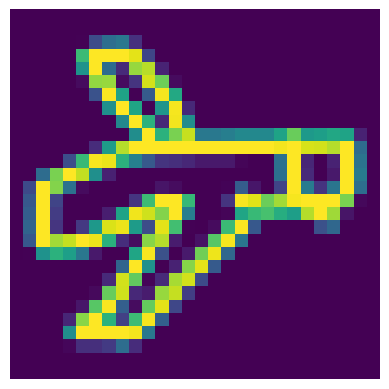

In [24]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Create the discriminator

It maps a 32x32 image to a binary classification score.

In [47]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        #layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        #layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 14, 14, 128)       2176      
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 7, 7, 128)         262272    
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_3 (Dropout)         (None, 6272)              0         
                                                                 
 dense_14 (Dense)            (None, 1)               

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [48]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 128),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        #layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        #layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 6272)              809088    
                                                                 
 reshape_11 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 14, 14, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 28, 28, 256)      524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 28, 28, 256)       0 

## Override `train_step`

In [49]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves generated images

In [50]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


## Train the end-to-end model

In [ ]:
epochs = 3  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/3
3153/5644 [===============>..............] - ETA: 2:34 - d_loss: 0.3586 - g_loss: 2.0979

# Wasserstein GAN

## Wasserstein GAN (WGAN) with Gradient Penalty (GP)

The original [Wasserstein GAN](https://arxiv.org/abs/1701.07875) leverages the
Wasserstein distance to produce a value function that has better theoretical
properties than the value function used in the original GAN paper. WGAN requires
that the discriminator (aka the critic) lie within the space of 1-Lipschitz
functions. The authors proposed the idea of weight clipping to achieve this
constraint. Though weight clipping works, it can be a problematic way to enforce
1-Lipschitz constraint and can cause undesirable behavior, e.g. a very deep WGAN
discriminator (critic) often fails to converge.

The [WGAN-GP](https://arxiv.org/abs/1704.00028) method proposes an
alternative to weight clipping to ensure smooth training. Instead of clipping
the weights, the authors proposed a "gradient penalty" by adding a loss term
that keeps the L2 norm of the discriminator gradients close to 1.

## Setup

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Prepare the Fashion-MNIST data

To demonstrate how to train WGAN-GP, we will be using the
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Each
sample in this dataset is a 28x28 grayscale image associated with a label from
10 classes (e.g. trouser, pullover, sneaker, etc.)

In [53]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

# Size of the noise vector
noise_dim = 128

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

4422102/4422102 [==============================] - 1s 0us/step
Number of examples: 60000
Shape of the images in the dataset: (28, 28)


In [55]:
train_labels[0].dtype

dtype('uint8')

## Create the discriminator (the critic in the original WGAN)

The samples in the dataset have a (28, 28, 1) shape. Because we will be
using strided convolutions, this can result in a shape with odd dimensions.
For example,
`(28, 28) -> Conv_s2 -> (14, 14) -> Conv_s2 -> (7, 7) -> Conv_s2 ->(3, 3)`.

While peforming upsampling in the generator part of the network, we won't get
the same input shape as the original images if we aren't careful. To avoid this,
we will do something much simpler:
- In the discriminator: "zero pad" the input to change the shape to `(32, 32, 1)`
for each sample; and
- Ihe generator: crop the final output to match the shape with input shape.

In [ ]:

def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

## Create the generator

In [ ]:

def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

## Create the WGAN-GP model

Now that we have defined our generator and discriminator, it's time to implement
the WGAN-GP model. We will also override the `train_step` for training.

In [ ]:

class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


## Create a Keras callback that periodically saves generated images

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


## Train the end-to-end model

In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Display the last generated images:

In [ ]:
from IPython.display import Image, display

display(Image("generated_img_0_19.png"))
display(Image("generated_img_1_19.png"))
display(Image("generated_img_2_19.png"))

Example available on HuggingFace.

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Model-WGAN%20GP-black.svg)](https://huggingface.co/keras-io/WGAN-GP) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-WGAN%20GP-black.svg)](https://huggingface.co/spaces/keras-io/WGAN-GP) |